## Set-up

In [1]:
import pandas as pd # library to create DataFrames
from scipy import stats # for statistics tests
from statsmodels.stats.outliers_influence import variance_inflation_factor # to calculate VIF values
import matplotlib.pyplot as plt # used for basic visualzations and graph creations

from sklearn.model_selection import train_test_split # use for Splitting the data between training data and test data
from sklearn.preprocessing import StandardScaler # for scaling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# library to read Excel files
!pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)

   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   ---------------------------------------- 2/2 [openpyxl]




[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# import biomarkers data into DataFrame
bioDF = pd.read_excel('biomarkers.xlsx')

In [3]:
# view the first 5 values of biomarkers patient data
bioDF.head()

,Biomarker,IL-8,VEGF-A,OPG,TGF-beta-1,IL-6,CXCL9,CXCL1,IL-18,CSF-1
0,126-0weeks,7.63,11.51,10.20,8.83,3.52,6.16,9.45,7.91,8.41
1,126-6weeks,7.12,11.59,10.41,8.87,3.89,6.12,9.06,7.92,8.39
2,127-0weeks,6.93,10.92,10.30,6.59,2.73,6.14,7.31,7.95,8.40
3,127-6weeks,7.16,11.58,10.39,8.61,2.60,6.35,8.61,7.94,8.51
4,127-12months,6.87,11.13,10.25,7.44,3.92,6.15,8.79,7.94,8.46


## Pre-processing

In [4]:
# split the first column by the '-' to identify the Patient ID and the timing of the biomarkers
bioDF[['PatientID', 'timing']] = bioDF['Biomarker'].str.split('-', expand=True)

# drop the 'Biomarker' column, since no longer needed
bioDF = bioDF.drop('Biomarker', axis=1)

# drop all rows except 'inclusion' time / 0weeks
inclusionDF = bioDF[bioDF['timing'].str.contains('0weeks$', regex=True)]

In [5]:
bioDF

,IL-8,VEGF-A,OPG,TGF-beta-1,IL-6,CXCL9,CXCL1,IL-18,CSF-1,PatientID,timing
0,7.63,11.51,10.20,8.83,3.52,6.16,9.45,7.91,8.41,126,0weeks
1,7.12,11.59,10.41,8.87,3.89,6.12,9.06,7.92,8.39,126,6weeks
2,6.93,10.92,10.30,6.59,2.73,6.14,7.31,7.95,8.40,127,0weeks
3,7.16,11.58,10.39,8.61,2.60,6.35,8.61,7.94,8.51,127,6weeks
4,6.87,11.13,10.25,7.44,3.92,6.15,8.79,7.94,8.46,127,12months
...,...,...,...,...,...,...,...,...,...,...,...
342,7.21,12.89,10.69,8.90,3.14,5.97,8.00,8.17,8.42,121,6weeks
343,6.35,11.01,9.96,6.70,2.55,4.68,7.34,7.76,8.11,121,12months
344,7.86,12.80,10.73,9.30,2.93,6.73,9.60,8.25,8.60,122,0weeks
345,8.52,13.04,10.81,8.79,2.94,6.73,9.64,8.19,8.64,122,6weeks


In [6]:
# reorder columns to start with 'PatientID'
inclusionDF = inclusionDF[['PatientID', 'timing', 'IL-8', 'VEGF-A', 'OPG', 'TGF-beta-1', 'IL-6', 'CXCL9', 'CXCL1', 'IL-18', 'CSF-1']]

In [7]:
# convert 'PatientID' to an integer value, sort by the integer value
inclusionDF['PatientID'] = inclusionDF['PatientID'].astype('int64')
inclusionDF = inclusionDF.sort_values('PatientID').reset_index(drop=True)

In [8]:
inclusionDF

,PatientID,timing,IL-8,VEGF-A,OPG,TGF-beta-1,IL-6,CXCL9,CXCL1,IL-18,CSF-1
0,1,0weeks,8.13,12.35,10.48,8.66,2.63,6.54,9.54,8.53,8.27
1,3,0weeks,6.55,11.21,10.49,6.83,2.58,5.31,6.71,7.71,8.30
2,4,0weeks,6.47,11.13,10.72,6.90,5.62,5.46,7.73,8.02,8.19
3,5,0weeks,6.41,11.15,10.60,7.26,1.96,5.35,7.15,7.66,8.10
4,6,0weeks,6.54,11.47,10.20,7.16,3.38,6.51,7.79,8.54,8.35
...,...,...,...,...,...,...,...,...,...,...,...
112,143,0weeks,6.67,11.12,10.60,6.55,3.41,6.67,6.60,7.26,8.32
113,149,0weeks,8.58,12.90,11.30,9.42,3.82,6.75,10.12,9.15,9.23
114,150,0weeks,6.15,11.05,10.43,7.16,4.47,6.06,6.36,7.95,8.48
115,151,0weeks,7.98,11.89,10.79,7.71,5.90,7.51,9.41,8.61,9.24


In [9]:
# confirm columns and datatypes, and no null values
inclusionDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PatientID   117 non-null    int64  
 1   timing      117 non-null    object 
 2   IL-8        117 non-null    float64
 3   VEGF-A      117 non-null    float64
 4   OPG         117 non-null    float64
 5   TGF-beta-1  117 non-null    float64
 6   IL-6        117 non-null    float64
 7   CXCL9       117 non-null    float64
 8   CXCL1       117 non-null    float64
 9   IL-18       117 non-null    float64
 10  CSF-1       117 non-null    float64
dtypes: float64(9), int64(1), object(1)
memory usage: 10.2+ KB


In [10]:
# import covatiates data into DataFrame
covariatesDF = pd.read_excel('covariates.xlsx')

In [11]:
covariatesDF

,PatientID,Age,"Sex (1=male, 2=female)","Smoker (1=yes, 2=no)",VAS-at-inclusion,Vas-12months
0,1,56,1,2,3.0,4.0
1,3,32,1,2,7.2,0.5
2,4,43,2,2,2.7,0.5
3,5,25,2,2,3.0,3.9
4,6,39,1,2,3.5,5.0
...,...,...,...,...,...,...
113,143,55,1,1,6.0,2.0
114,149,46,2,2,5.0,9.0
115,150,57,1,1,1.0,9.0
116,151,25,2,2,8.0,6.0


In [12]:
# confirm columns and datatypes, and no null values
covariatesDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               118 non-null    int64  
 1   Age                     118 non-null    int64  
 2   Sex (1=male, 2=female)  118 non-null    int64  
 3   Smoker (1=yes, 2=no)    118 non-null    int64  
 4   VAS-at-inclusion        118 non-null    float64
 5   Vas-12months            116 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 5.7 KB


In [13]:
# identify the extra patient in covariates DataFrame, patient 40 that does not have biomarker values for '0week'
extra_ids = set(inclusionDF['PatientID']).symmetric_difference(covariatesDF['PatientID'])
extra_ids

{40}

In [14]:
# remove patient 40 from covariates DataFrame
covariatesDF = covariatesDF[covariatesDF['PatientID'] != 40]

In [15]:
# shorten column names
covariatesDF = covariatesDF.rename(columns={'VAS-at-inclusion': 'VAS0', 'Vas-12months': 'VAS12',
                                           'Sex (1=male, 2=female)': 'Sex (1=M, 2=F)', 'Smoker (1=yes, 2=no)': 'Smoker (1=Y, 2=N)'})

In [16]:
# join the two DataFrames with an inner join matching Patient IDs
analysisDF = pd.merge(inclusionDF, covariatesDF, on='PatientID', how='inner')

In [17]:
analysisDF

,PatientID,timing,IL-8,VEGF-A,OPG,TGF-beta-1,IL-6,CXCL9,CXCL1,IL-18,CSF-1,Age,"Sex (1=M, 2=F)","Smoker (1=Y, 2=N)",VAS0,VAS12
0,1,0weeks,8.13,12.35,10.48,8.66,2.63,6.54,9.54,8.53,8.27,56,1,2,3.0,4.0
1,3,0weeks,6.55,11.21,10.49,6.83,2.58,5.31,6.71,7.71,8.30,32,1,2,7.2,0.5
2,4,0weeks,6.47,11.13,10.72,6.90,5.62,5.46,7.73,8.02,8.19,43,2,2,2.7,0.5
3,5,0weeks,6.41,11.15,10.60,7.26,1.96,5.35,7.15,7.66,8.10,25,2,2,3.0,3.9
4,6,0weeks,6.54,11.47,10.20,7.16,3.38,6.51,7.79,8.54,8.35,39,1,2,3.5,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,143,0weeks,6.67,11.12,10.60,6.55,3.41,6.67,6.60,7.26,8.32,55,1,1,6.0,2.0
113,149,0weeks,8.58,12.90,11.30,9.42,3.82,6.75,10.12,9.15,9.23,46,2,2,5.0,9.0
114,150,0weeks,6.15,11.05,10.43,7.16,4.47,6.06,6.36,7.95,8.48,57,1,1,1.0,9.0
115,151,0weeks,7.98,11.89,10.79,7.71,5.90,7.51,9.41,8.61,9.24,25,2,2,8.0,6.0


In [18]:
# confirm columns and datatypes, and 2 null values
analysisDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PatientID          117 non-null    int64  
 1   timing             117 non-null    object 
 2   IL-8               117 non-null    float64
 3   VEGF-A             117 non-null    float64
 4   OPG                117 non-null    float64
 5   TGF-beta-1         117 non-null    float64
 6   IL-6               117 non-null    float64
 7   CXCL9              117 non-null    float64
 8   CXCL1              117 non-null    float64
 9   IL-18              117 non-null    float64
 10  CSF-1              117 non-null    float64
 11  Age                117 non-null    int64  
 12  Sex (1=M, 2=F)     117 non-null    int64  
 13  Smoker (1=Y, 2=N)  117 non-null    int64  
 14  VAS0               117 non-null    float64
 15  VAS12              115 non-null    float64
dtypes: float64(11), int64(4), 

In [19]:
# drop the two records with null values
analysisDF = analysisDF.dropna(subset=['VAS12'])

In [20]:
analysisDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115 entries, 0 to 116
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PatientID          115 non-null    int64  
 1   timing             115 non-null    object 
 2   IL-8               115 non-null    float64
 3   VEGF-A             115 non-null    float64
 4   OPG                115 non-null    float64
 5   TGF-beta-1         115 non-null    float64
 6   IL-6               115 non-null    float64
 7   CXCL9              115 non-null    float64
 8   CXCL1              115 non-null    float64
 9   IL-18              115 non-null    float64
 10  CSF-1              115 non-null    float64
 11  Age                115 non-null    int64  
 12  Sex (1=M, 2=F)     115 non-null    int64  
 13  Smoker (1=Y, 2=N)  115 non-null    int64  
 14  VAS0               115 non-null    float64
 15  VAS12              115 non-null    float64
dtypes: float64(11), int64(4), objec

In [21]:
analysisDF.describe()

,PatientID,IL-8,VEGF-A,OPG,TGF-beta-1,IL-6,CXCL9,CXCL1,IL-18,CSF-1,Age,"Sex (1=M, 2=F)","Smoker (1=Y, 2=N)",VAS0,VAS12
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,76.260870,7.725826,11.879304,10.732174,8.236435,3.345130,6.624783,8.672348,8.376435,8.598609,41.008696,1.495652,1.669565,5.998261,3.633913
std,43.591221,0.893572,0.673865,0.425075,0.929277,0.998363,0.901994,1.237968,0.601398,0.289470,10.170042,0.502169,0.472428,2.689028,3.089595
min,1.000000,5.500000,10.600000,9.670000,6.550000,1.810000,5.250000,6.170000,6.890000,7.950000,18.000000,1.000000,1.000000,0.000000,0.000000
25%,38.500000,7.010000,11.355000,10.480000,7.445000,2.655000,6.110000,7.655000,7.985000,8.390000,32.000000,1.000000,1.000000,4.000000,0.700000
50%,75.000000,7.790000,11.810000,10.660000,8.430000,3.080000,6.560000,9.070000,8.350000,8.560000,41.000000,1.000000,2.000000,6.500000,3.500000
75%,113.500000,8.290000,12.425000,10.910000,8.995000,3.790000,6.970000,9.635000,8.750000,8.755000,49.000000,2.000000,2.000000,8.000000,6.000000
max,152.000000,11.330000,13.510000,11.850000,9.910000,7.910000,11.510000,11.190000,9.780000,9.780000,59.000000,2.000000,2.000000,10.000000,10.000000


In [22]:
male_df = analysisDF[analysisDF['Sex (1=M, 2=F)'] == 1]
female_df = analysisDF[analysisDF['Sex (1=M, 2=F)'] == 2]

In [23]:
male_df.describe()

,PatientID,IL-8,VEGF-A,OPG,TGF-beta-1,IL-6,CXCL9,CXCL1,IL-18,CSF-1,Age,"Sex (1=M, 2=F)","Smoker (1=Y, 2=N)",VAS0,VAS12
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.0,58.000000,58.000000,58.000000
mean,75.431034,7.648966,11.753448,10.672586,8.082586,3.241897,6.616552,8.376552,8.448966,8.526379,41.775862,1.0,1.603448,6.389655,3.658621
std,43.382474,0.926091,0.626955,0.442911,0.932991,0.849403,0.869044,1.205334,0.609296,0.226093,10.642588,0.0,0.493454,2.704557,3.201263
min,1.000000,5.500000,10.700000,9.670000,6.550000,1.810000,5.250000,6.170000,7.260000,7.950000,18.000000,1.0,1.000000,0.000000,0.000000
25%,38.250000,6.870000,11.180000,10.435000,7.152500,2.640000,6.072500,7.295000,8.000000,8.365000,33.000000,1.0,1.000000,5.000000,0.500000
50%,72.500000,7.750000,11.655000,10.605000,8.210000,3.015000,6.565000,8.935000,8.425000,8.520000,42.000000,1.0,2.000000,7.000000,3.500000
75%,112.000000,8.285000,12.257500,10.797500,8.862500,3.700000,6.975000,9.327500,8.817500,8.662500,50.000000,1.0,2.000000,8.375000,5.875000
max,152.000000,10.190000,13.130000,11.810000,9.580000,5.240000,10.780000,9.960000,9.780000,9.050000,59.000000,1.0,2.000000,10.000000,10.000000


In [24]:
female_df.describe()

,PatientID,IL-8,VEGF-A,OPG,TGF-beta-1,IL-6,CXCL9,CXCL1,IL-18,CSF-1,Age,"Sex (1=M, 2=F)","Smoker (1=Y, 2=N)",VAS0,VAS12
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.0,57.000000,57.000000,57.000000
mean,77.105263,7.804035,12.007368,10.792807,8.392982,3.450175,6.633158,8.973333,8.302632,8.672105,40.228070,2.0,1.736842,5.600000,3.608772
std,44.172019,0.860321,0.700868,0.400922,0.906906,1.128014,0.942008,1.207585,0.589417,0.328094,9.697234,0.0,0.444262,2.637166,2.999957
min,4.000000,6.290000,10.600000,9.970000,6.570000,1.960000,5.270000,6.240000,6.890000,8.100000,22.000000,2.0,1.000000,0.300000,0.000000
25%,43.000000,7.240000,11.500000,10.550000,7.780000,2.740000,6.110000,7.730000,7.980000,8.490000,32.000000,2.0,1.000000,3.000000,1.000000
50%,76.000000,7.790000,12.090000,10.790000,8.510000,3.230000,6.550000,9.320000,8.190000,8.650000,41.000000,2.0,2.000000,6.000000,3.500000
75%,118.000000,8.290000,12.530000,11.060000,9.090000,4.000000,6.960000,9.920000,8.660000,8.830000,46.000000,2.0,2.000000,8.000000,6.000000
max,151.000000,11.330000,13.510000,11.850000,9.910000,7.910000,11.510000,11.190000,9.780000,9.780000,59.000000,2.0,2.000000,10.000000,9.500000


## T-Statistics and p-values

In [25]:
# identify the data for analysis
biomarkers = ['IL-8', 'VEGF-A', 'OPG', 'TGF-beta-1', 'IL-6', 
        'CXCL9', 'CXCL1', 'IL-18', 'CSF-1']

# male and female column
sex_column = "Sex (1=M, 2=F)"

In [26]:
# create DataFrames for males and females
males_data = analysisDF[analysisDF[sex_column] == 1]
females_data = analysisDF[analysisDF[sex_column] == 2]

print(f"Number of males (Sex=1) at '0weeks': {len(males_data)}")
print(f"Number of females (Sex=2) at '0weeks': {len(females_data)}")

Number of males (Sex=1) at '0weeks': 58
Number of females (Sex=2) at '0weeks': 57


In [27]:
results = {}
alpha = 0.05

for biomarker in biomarkers:
        # get data for each group
        male_values1 = males_data[biomarker]
        female_values1 = females_data[biomarker]

        # perform Welch's T-test (does not assume equal variance)
        # H0: The means of the two groups are equal
        # H1: The means of the two groups are not equal
        t_stat, p_value = stats.ttest_ind(
            male_values1, 
            female_values1, 
            equal_var=False 
        )
        
        results[biomarker] = (t_stat, p_value)

In [28]:
# print formatted results
print(f"\n{'Biomarker':<12} | {'T-Statistic':<12} | {'P-Value':<12} | {'Significant (p < 0.05)?'}")
print("-" * 60)
for biomarker, (t_stat, p_value) in results.items():
    # H0 is rejected if p_value < 0.05
    significance = "Yes" if p_value < alpha else "No"
    print(f"{biomarker:<12} | {t_stat:>12.4f} | {p_value:>12.4f} | {significance}")


Biomarker    | T-Statistic  | P-Value      | Significant (p < 0.05)?
------------------------------------------------------------
IL-8         |      -0.9305 |       0.3541 | No
VEGF-A       |      -2.0465 |       0.0431 | Yes
OPG          |      -1.5265 |       0.1297 | No
TGF-beta-1   |      -1.8091 |       0.0731 | No
IL-6         |      -1.1171 |       0.2665 | No
CXCL9        |      -0.0982 |       0.9219 | No
CXCL1        |      -2.6522 |       0.0091 | Yes
IL-18        |       1.3091 |       0.1932 | No
CSF-1        |      -2.7689 |       0.0067 | Yes


## Variance Inflation Factor

It is expected that these biomarkers are inter-related . Therefore, using the **VIF (Variance Inflation Factor)** that measures how well an attribute can be predicted by a linear combination of all the other attributes will be evaluated.

$VIF_i = \frac{1}{1 - R_i^2}$

In [29]:
def calculate_vif(df):
    """
    Calculate VIF for all float64 features in the dataframe.
    
    Parameters:
    -----------
    df : temporary DataFrame containing only the biomarkers to analyze
        
    Returns:
    --------
    temporary DataFrame with biomarkers and their VIF values
    """
    
    vif_data = pd.DataFrame() # temporary DataFrame
    vif_data["Feature"] = df.columns # attributes of input DataFrame
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) 
                       for i in range(df.shape[1])]
    return vif_data

def remove_high_vif_biomarkers(df, threshold=5.0):
    """
    Recursively remove biomarkers with high VIF until all VIF values are below threshold
    
    Parameters:
    -----------
    df : temporary DataFrame containing only the biomarkers to analyze
    
    threshold : float, default=5.0
        VIF threshold above which biomarkers should be removed
        
    Returns:
    --------
    tuple: (biomarkers_kept, removed_biomarkers)
        The remaining biomarkers
        The biomarker that was removed
    """
    
    biomarkers_kept = df.copy()
    removed_biomarkers = []
    
    print(f"Conducting a VIF analysis with threshold: {threshold}")
    
    iteration = 1
    while True:
        # calculate VIF for current biomarkers
        vif_df = calculate_vif(biomarkers_kept) # call above function
        
        print(f"Iteration {iteration}:")
        print(vif_df.sort_values('VIF', ascending=False).to_string(index=False))
        print()
        
        # identify the highest VIF value to remove
        max_vif = vif_df['VIF'].max()
        
        # once all VIF values are below threshold of 5, stop the process
        if max_vif <= threshold:
            print(f"All VIF values are below threshold ({threshold})")
            print(f"Final number of biomarkers: {len(biomarkers_kept.columns)}")
            break
        
        # remove the feature with the highest VIF
        biomarker_removed = vif_df.loc[vif_df['VIF'].idxmax(), 'Feature']
        print(f"Removing '{biomarker_removed}' (VIF = {max_vif:.2f})\n")
        
        removed_biomarkers.append((biomarker_removed, max_vif))
        biomarkers_kept = biomarkers_kept.drop(columns=[biomarker_removed])
        
        iteration += 1
    
    return biomarkers_kept, removed_biomarkers

In [30]:
biomarkers = analysisDF[['IL-8', 'VEGF-A', 'OPG', 'TGF-beta-1', 'IL-6', 
        'CXCL9', 'CXCL1', 'IL-18', 'CSF-1']]

remaining_biomarkers, removed_list = remove_high_vif_biomarkers(biomarkers, threshold=15.0)

# use the remaining features for the model
print(f"These biomarkers were removed: {removed_list}")
print()
print(f"These biomarkers will be used: {list(remaining_biomarkers.columns)}")

Conducting a VIF analysis with threshold: 15.0
Iteration 1:
   Feature         VIF
     CSF-1 1425.224654
    VEGF-A  936.479456
       OPG  795.108230
TGF-beta-1  403.786078
      IL-8  246.717581
     IL-18  244.515302
     CXCL1  223.667400
     CXCL9   80.250400
      IL-6   14.506864

Removing 'CSF-1' (VIF = 1425.22)

Iteration 2:
   Feature        VIF
    VEGF-A 702.215087
       OPG 463.553324
TGF-beta-1 403.769677
      IL-8 227.795370
     CXCL1 223.647475
     IL-18 213.762222
     CXCL9  70.533244
      IL-6  14.504588

Removing 'VEGF-A' (VIF = 702.22)

Iteration 3:
   Feature        VIF
TGF-beta-1 324.761031
       OPG 284.397841
      IL-8 226.574090
     CXCL1 223.548263
     IL-18 196.037518
     CXCL9  69.628292
      IL-6  14.465220

Removing 'TGF-beta-1' (VIF = 324.76)

Iteration 4:
Feature        VIF
    OPG 269.038902
   IL-8 217.974080
  IL-18 192.023800
  CXCL1 116.468420
  CXCL9  68.444160
   IL-6  14.456332

Removing 'OPG' (VIF = 269.04)

Iteration 5:
Feature   

## Type I Error Probability

In [31]:
# alpha = 0.05, significance level
num_tests = 9 # number of biomarkers tested

In [32]:
# single test Type I Error
print("1. SINGLE TEST:")
print(f"   Significance level (α) = {alpha}")
print(f"   Probability of Type I error in ONE test = {alpha:.4f} ({alpha*100:.2f}%)")

1. SINGLE TEST:
   Significance level (α) = 0.05
   Probability of Type I error in ONE test = 0.0500 (5.00%)


In [33]:
# multiple tests using Family-Wise Error Rate (FWER)
fwer = 1 - (1 - alpha)**num_tests
print("2. MULTIPLE TESTS:")
print(f"   Number of tests = {num_tests} biomarkers")
print(f"   Probability of making AT LEAST ONE Type I error (FWER):")
print(f"   FWER = 1 - (1 - α)^k")
print(f"   FWER = 1 - (1 - {alpha})^{num_tests}")
print(f"   FWER = {fwer:.4f} ({fwer*100:.2f}%)")

2. MULTIPLE TESTS:
   Number of tests = 9 biomarkers
   Probability of making AT LEAST ONE Type I error (FWER):
   FWER = 1 - (1 - α)^k
   FWER = 1 - (1 - 0.05)^9
   FWER = 0.3698 (36.98%)


In [34]:
# expected number of Type I errors
expected_type1_errors = num_tests * alpha
print("3. EXPECTED NUMBER OF FALSE POSITIVES:")
print(f"   Expected Type I errors = k × α = {num_tests} × {alpha} = {expected_type1_errors:.2f}")
print()

3. EXPECTED NUMBER OF FALSE POSITIVES:
   Expected Type I errors = k × α = 9 × 0.05 = 0.45



In [35]:
# Bonferroni correction
bonferroni_alpha = alpha / num_tests
print(f"a) Bonferroni Correction:")
print(f"   Adjusted α = α / k = {alpha} / {num_tests} = {bonferroni_alpha:.6f}")
print(f"   New threshold: p_value < {bonferroni_alpha:.6f}")

a) Bonferroni Correction:
   Adjusted α = α / k = 0.05 / 9 = 0.005556
   New threshold: p_value < 0.005556


In [36]:
# print formatted results
print(f"\n{'Biomarker':<12} | {'T-Statistic':<12} | {'P-Value':<12} | {'Significant (p < 0.05)'} | With Bonferroni: {bonferroni_alpha:.4f}")
print("-" * 92)
for biomarker, (t_stat, p_value) in results.items():
    # H0 is rejected if p_value < 0.05
    significance = "Yes" if p_value < alpha else "No"
    bonferroni = "Yes" if p_value < bonferroni_alpha else "No"
    print(f"{biomarker:<12} | {t_stat:>12.4f} | {p_value:>12.4f} | {significance:>22} | {bonferroni:>15}")


Biomarker    | T-Statistic  | P-Value      | Significant (p < 0.05) | With Bonferroni: 0.0056
--------------------------------------------------------------------------------------------
IL-8         |      -0.9305 |       0.3541 |                     No |              No
VEGF-A       |      -2.0465 |       0.0431 |                    Yes |              No
OPG          |      -1.5265 |       0.1297 |                     No |              No
TGF-beta-1   |      -1.8091 |       0.0731 |                     No |              No
IL-6         |      -1.1171 |       0.2665 |                     No |              No
CXCL9        |      -0.0982 |       0.9219 |                     No |              No
CXCL1        |      -2.6522 |       0.0091 |                    Yes |              No
IL-18        |       1.3091 |       0.1932 |                     No |              No
CSF-1        |      -2.7689 |       0.0067 |                    Yes |              No


## Linear Regression

In [37]:
def create_scatter_subplots(dataframe, attributes, target):
    """
    Creates 9 subplots showing scatter plots for 9 numerical
    attributes versus the numerical target value.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        attributes (list): A list of 5 column names for the numerical attributes.
        target (str): The column name for the numerical target value.
    """
    # create a figure and a set of six subplots across 3 rows and 2 columns
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
    # flatten the axes array for iteration
    axes = axes.flatten()

    # set colours for male and female
    colors = {1: '#00008B', 2: '#FF47AF'}  # Blue for male, red for female
    # labels = {1: 'Male', 2: 'Female'}

    # create a scatter plot for each attribute and the target variable VAS12
    for i, attr in enumerate(attributes):
        # Plot each sex separately to enable legend
        for sex_val in [1, 2]:
            mask = dataframe['Sex (1=M, 2=F)'] == sex_val
            axes[i].scatter(
                dataframe.loc[mask, attr], 
                dataframe.loc[mask, target],
                c=colors[sex_val],
                # label=labels[sex_val],
                alpha=0.8,
                edgecolors='w',
                linewidth=0.5
            )
        axes[i].set_title(f'{attr} vs {target}')
        axes[i].set_xlabel(attr)
        axes[i].set_ylabel(target)


    # adjust layout to prevent titles and labels from overlapping
    plt.tight_layout()
    plt.show()

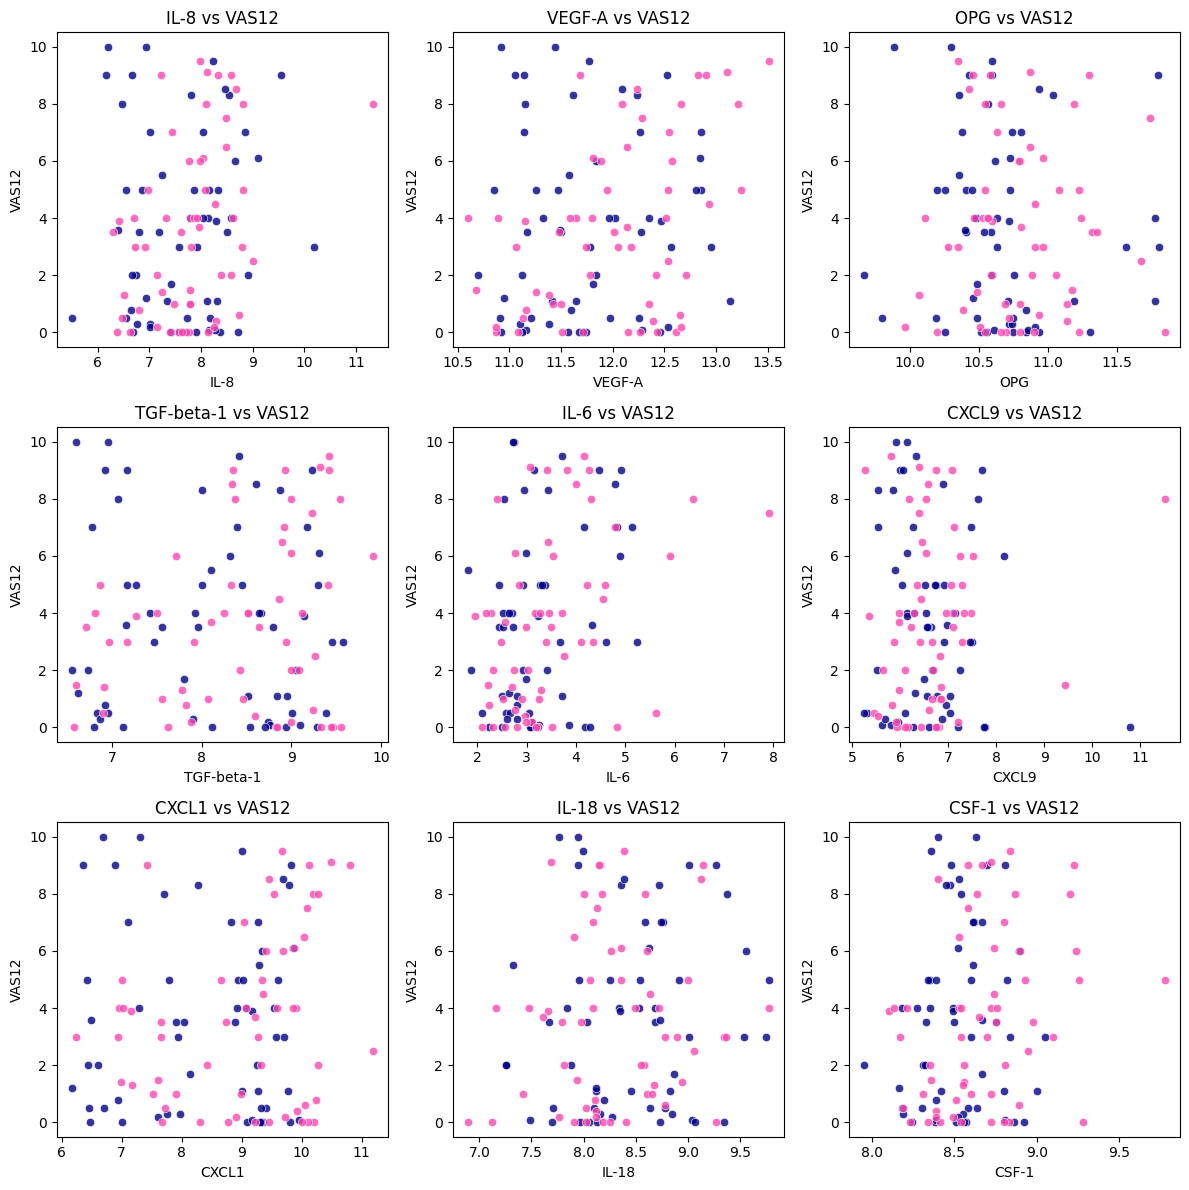

In [38]:
numerical_attributes = ['IL-8', 'VEGF-A', 'OPG', 'TGF-beta-1', 'IL-6', 
        'CXCL9', 'CXCL1', 'IL-18', 'CSF-1']
target_value = 'VAS12'

# call the above function to create the scatter subplots
create_scatter_subplots(analysisDF, numerical_attributes, target_value)

In [39]:
analysisDF = analysisDF.copy()

# convert 'Sex' and 'Smoker' attributes to binary variables of '0' and '1' instead of ordinal ranking of '2' is double '1'
analysisDF.loc[:, 'Sex (1=M, 2=F)'] = analysisDF['Sex (1=M, 2=F)'].map({1: 0, 2: 1})
analysisDF.loc[:, 'Smoker (1=Y, 2=N)'] = analysisDF['Smoker (1=Y, 2=N)'].map({1: 0, 2: 1})

# update column names
analysisDF.rename(columns={'Sex (1=M, 2=F)': 'Sex (0=M, 1=F)',
    'Smoker (1=Y, 2=N)': 'Smoker (0=Y, 1=N)'}, inplace=True)

# drop PatientID, timing and VAS0 columns
analysisDF.drop(['PatientID', 'timing', 'VAS0'], axis=1, inplace=True)

In [40]:
analysisDF

,IL-8,VEGF-A,OPG,TGF-beta-1,IL-6,CXCL9,CXCL1,IL-18,CSF-1,Age,"Sex (0=M, 1=F)","Smoker (0=Y, 1=N)",VAS12
0,8.13,12.35,10.48,8.66,2.63,6.54,9.54,8.53,8.27,56,0,1,4.0
1,6.55,11.21,10.49,6.83,2.58,5.31,6.71,7.71,8.30,32,0,1,0.5
2,6.47,11.13,10.72,6.90,5.62,5.46,7.73,8.02,8.19,43,1,1,0.5
3,6.41,11.15,10.60,7.26,1.96,5.35,7.15,7.66,8.10,25,1,1,3.9
4,6.54,11.47,10.20,7.16,3.38,6.51,7.79,8.54,8.35,39,0,1,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,6.67,11.12,10.60,6.55,3.41,6.67,6.60,7.26,8.32,55,0,0,2.0
113,8.58,12.90,11.30,9.42,3.82,6.75,10.12,9.15,9.23,46,1,1,9.0
114,6.15,11.05,10.43,7.16,4.47,6.06,6.36,7.95,8.48,57,0,0,9.0
115,7.98,11.89,10.79,7.71,5.90,7.51,9.41,8.61,9.24,25,1,1,6.0


In [41]:
# split data into Training and Testing, with 80% for Training

y = analysisDF['VAS12']
xTrain, xTest, yTrain, yTest = train_test_split(analysisDF.drop('VAS12', axis=1), y, test_size=0.2, random_state=42)

In [42]:
# confirming matching shapes of all DataFrames
print(xTrain.shape, xTest.shape, yTrain.shape, yTest.shape)

(92, 12) (23, 12) (92,) (23,)


### Standardize Numeric Columns

In [43]:
# continuous numerical columns to be standardized
# all biomarker columns (continuous measurements)
# age (a continuous demographic variable)
continuous_values = ['IL-8', 'VEGF-A', 'OPG', 'TGF-beta-1', 'IL-6', 
        'CXCL9', 'CXCL1', 'IL-18', 'CSF-1', 'Age']

In [44]:
scaler = StandardScaler()

In [45]:
# fit the scaler on training data only to prevent data leakage
xTrainScaled = xTrain.copy()
xTestScaled = xTest.copy()

In [46]:
# standardize only the continuous columns; apply training scaler to test
xTrainScaled[continuous_values] = scaler.fit_transform(xTrain[continuous_values])
xTestScaled[continuous_values] = scaler.transform(xTest[continuous_values])

In [47]:
# scaling statistics, fitted on training data
print(f"\nMeans of continuous features (should be ~0 after scaling training data):")
for col in continuous_values[:]:  # Show first 3 for brevity
    print(f"  {col}: {xTrainScaled[col].mean():.6f}")

print(f"\nStandard deviations of continuous features (should be ~1 after scaling training data):")
for col in continuous_values[:]:  # Show first 3 for brevity
    print(f"  {col}: {xTrainScaled[col].std():.6f}")


Means of continuous features (should be ~0 after scaling training data):
  IL-8: -0.000000
  VEGF-A: -0.000000
  OPG: -0.000000
  TGF-beta-1: -0.000000
  IL-6: 0.000000
  CXCL9: -0.000000
  CXCL1: -0.000000
  IL-18: -0.000000
  CSF-1: 0.000000
  Age: 0.000000

Standard deviations of continuous features (should be ~1 after scaling training data):
  IL-8: 1.005479
  VEGF-A: 1.005479
  OPG: 1.005479
  TGF-beta-1: 1.005479
  IL-6: 1.005479
  CXCL9: 1.005479
  CXCL1: 1.005479
  IL-18: 1.005479
  CSF-1: 1.005479
  Age: 1.005479


### Linear Regression Model

In [48]:
# VAS12 linear regression
vasLR = LinearRegression()
vasLR.fit(xTrainScaled, yTrain)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [49]:
print(f"Number of features used: {len(vasLR.coef_)}")

Number of features used: 12


### Evaluation

In [50]:
# Predictions on training set
yTrainPred = vasLR.predict(xTrainScaled)

# Predictions on test set
yTestPred = vasLR.predict(xTestScaled)

In [51]:
# training set metrics
train_mse = mean_squared_error(yTrain, yTrainPred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(yTrain, yTrainPred)
train_r2 = r2_score(yTrain, yTrainPred)

print("\nTRAINING SET:")
print(f"  R² Score:             {train_r2:.4f}")
print(f"  Mean Squared Error:   {train_mse:.4f}")
print(f"  Root Mean Squared Error: {train_rmse:.4f}")
print(f"  Mean Absolute Error:  {train_mae:.4f}")


TRAINING SET:
  R² Score:             0.2543
  Mean Squared Error:   7.0054
  Root Mean Squared Error: 2.6468
  Mean Absolute Error:  2.2362


In [52]:
# Test set metrics
test_mse = mean_squared_error(yTest, yTestPred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(yTest, yTestPred)
test_r2 = r2_score(yTest, yTestPred)

print("\nTEST SET:")
print(f"  R² Score:             {test_r2:.4f}")
print(f"  Mean Squared Error:   {test_mse:.4f}")
print(f"  Root Mean Squared Error: {test_rmse:.4f}")
print(f"  Mean Absolute Error:  {test_mae:.4f}")


TEST SET:
  R² Score:             0.2401
  Mean Squared Error:   7.3952
  Root Mean Squared Error: 2.7194
  Mean Absolute Error:  2.2832


In [53]:
# Check for overfitting
r2_diff = train_r2 - test_r2
print(f"R² difference (train - test): {r2_diff:.4f}")
if r2_diff > 0.1:
    print("Warning: Potential overfitting detected (R² difference > 0.1)")
elif r2_diff < 0:
    print("Model generalizes well (test R² >= train R²)")
else:
    print("Model appears to generalize reasonably well")

R² difference (train - test): 0.0142
Model appears to generalize reasonably well


In [54]:
# compare Y Test Predictions with Y Test Data using a comparison DataFrame
comparisonDF = pd.DataFrame({
    'Actual': yTest,
    'Predicted': yTestPred,
    'Difference': yTestPred - yTest,
    'Abs_Difference': np.abs(yTestPred - yTest)
})

# add original index for reference, and sort by Actual
comparisonDF['Original Index'] = yTest.index
comparisonDF = comparisonDF.sort_values('Actual', ascending=False)

# filter for predictions where absolute difference > 2.3, the MAE
large_errors = comparisonDF[comparisonDF['Abs_Difference'] > test_mae].copy()

# sort by absolute difference
large_errors = large_errors.sort_values('Abs_Difference', ascending=False)

print(f"\nTotal test samples: {len(comparisonDF)}")
print(f"Samples with |error| > 2.3: {len(large_errors)} ({len(large_errors)/len(comparisonDF)*100:.1f}%)")
print(f"Samples with |error| ≤ 2.3: {len(comparisonDF) - len(large_errors)} ({(len(comparisonDF)-len(large_errors))/len(comparisonDF)*100:.1f}%)")

print("\n" + "=" * 40)
print("PREDICTIONS WITH ABSOLUTE ERROR > 2.3:")
print("=" * 40)
print(f"\n{'Index':<8} {'Actual':<10} {'Predicted':<10} {'|Error|':<10}")
print("-" * 40)

for idx, row in comparisonDF.iterrows():
    print(f"{row['Original Index']:<8} {row['Actual']:<10.1f} {row['Predicted']:<10.2f} {row['Abs_Difference']:<10.2f}")


Total test samples: 23
Samples with |error| > 2.3: 10 (43.5%)
Samples with |error| ≤ 2.3: 13 (56.5%)

PREDICTIONS WITH ABSOLUTE ERROR > 2.3:

Index    Actual     Predicted  |Error|   
----------------------------------------
96.0     10.0       3.72       6.28      
114.0    9.0        3.50       5.50      
86.0     9.0        6.59       2.41      
72.0     8.3        5.18       3.12      
68.0     6.5        3.84       2.66      
115.0    6.0        7.84       1.84      
4.0      5.0        3.46       1.54      
71.0     4.0        2.92       1.08      
102.0    4.0        2.09       1.91      
0.0      4.0        2.78       1.22      
107.0    3.9        3.62       0.28      
11.0     3.5        2.71       0.79      
18.0     3.5        2.33       1.17      
74.0     3.0        5.86       2.86      
10.0     1.4        3.73       2.33      
37.0     1.1        5.08       3.98      
12.0     1.1        1.04       0.06      
83.0     1.0        3.06       2.06      
26.0     0.5      